In [6]:
# LPF method for VLS-SG
import numpy as np
# Grating equation 
def diffraction_beta_rad(chief_ray_alpha_rad, a0_mm, wavelength_mm, diffraction_order):
    return  np.arcsin( a0_mm * diffraction_order * wavelength_mm + np.sin(chief_ray_alpha_rad) )
   
def sphere_grating_parameter(alpha_rad, a0, wavelength_mm, diffraction_order, r1, r2, R):
    beta_rad = diffraction_beta_rad(alpha_rad, a0, wavelength_mm, diffraction_order)
    T_src = np.cos(alpha_rad)**2 / r1 - np.cos(alpha_rad) / R
    T_img = np.cos(beta_rad)**2 / r2 - np.cos(beta_rad) / R

    a1 = -(T_src + T_img) / (diffraction_order * wavelength_mm)
    a2 = (3/2) * (np.sin(alpha_rad) / r1 * T_src - np.sin(beta_rad) / r2 * T_img) / (diffraction_order * wavelength_mm)
    a3 = -0.5 * (4 * (np.sin(alpha_rad) / r1)**2 * T_src - 1 / r1 * T_src**2 + 1 / R**2 * (1 / r1 - np.cos(alpha_rad) / R)
                + 4 * (np.sin(beta_rad) / r2)**2 * T_img - 1 / r2 * T_img**2 + 1 / R**2 * (1 / r2 - np.cos(beta_rad) / R)) / (diffraction_order * wavelength_mm)
    return [a1, a2, a3]

energy = 400
a0_mm = 2400
hc = 1.23984193e-3 
diffraction_order = -1
R = 27156.18669535969
chief_ray_alpha_deg = 87.2       # incident alpha; unit [deg.]
r1 = 795.9                  # incoming length r1; unit [mm]
r2 = 3288.1                # outgoing length r2; unit [mm]

chief_ray_beta_rad = diffraction_beta_rad(chief_ray_alpha_deg/180*np.pi, hc/energy,  a0_mm, diffraction_order)
print(chief_ray_beta_rad/np.pi*180)

a_parameter_arrays = sphere_grating_parameter(chief_ray_alpha_deg/180*np.pi, a0_mm, hc/energy, diffraction_order, r1, r2, R)
print(a_parameter_arrays)
print("Gooves parameter for plane VLS grating\n"+
      "a0 =",a0_mm,"[mm-1]\n"+
      "a1 =",a_parameter_arrays[0],"[mm-2]\n"+
      "a2 =",a_parameter_arrays[1],"[mm-3]\n"+
      "a3 =",a_parameter_arrays[2],"[mm-4]\n")

a0_VLSSG = a0_mm
a1_VLSSG = a_parameter_arrays[0]
a2_VLSSG = a_parameter_arrays[1]
a3_VLSSG = a_parameter_arrays[2]
R_VLSSG = R

82.46593652624586
[0.516043592408408, -0.0006700182062792407, 1.5818752183595324e-06]
Gooves parameter for plane VLS grating
a0 = 2400 [mm-1]
a1 = 0.516043592408408 [mm-2]
a2 = -0.0006700182062792407 [mm-3]
a3 = 1.5818752183595324e-06 [mm-4]



Data saved to LPF_data_fixe_alpha.xlsx


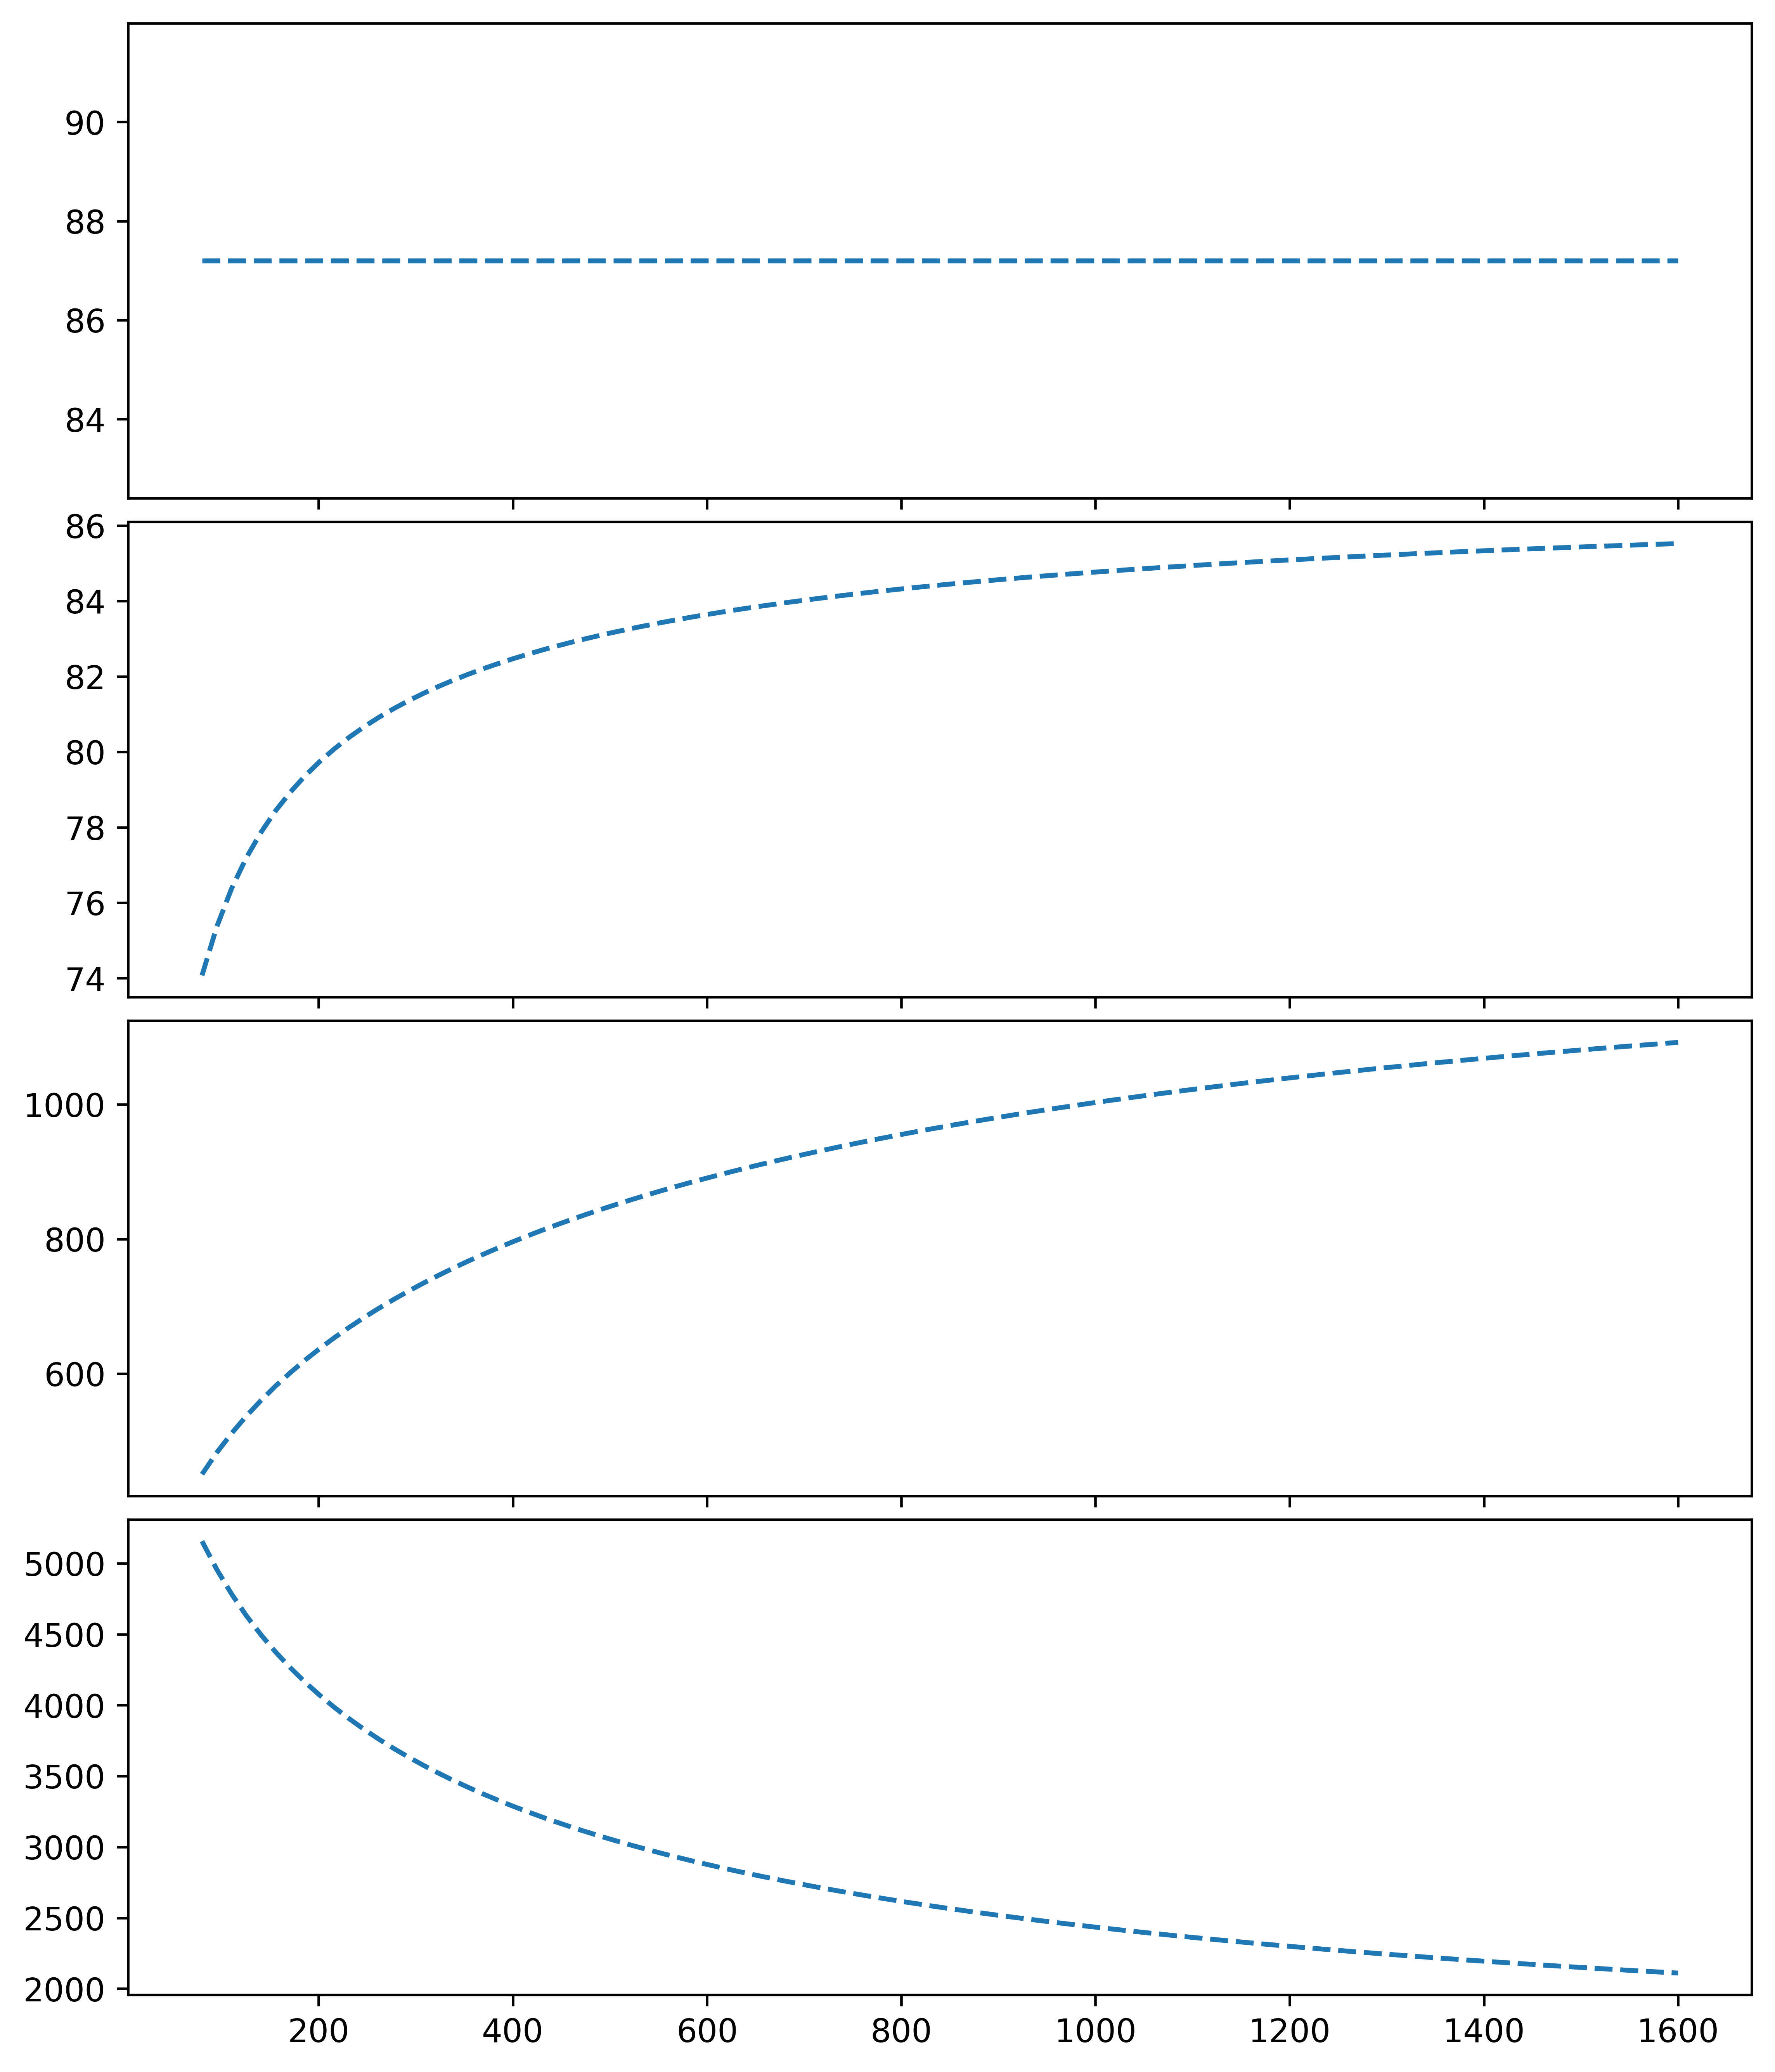

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

start_energy = 80
end_energy = 1600
energy_array = np.linspace(start_energy,end_energy,101)
alpha_LPF_focal_array =  np.zeros(len(energy_array))
beta_LPF_focal_array = np.zeros(len(energy_array))
r1_LPF_focal_array = np.zeros(len(energy_array))
r2_LPF_focal_array = np.zeros(len(energy_array))

def focu_posi_SGVLS(alpha_rad, wavelength_mm, diffraction_order, a0, a1, a2, a3, R):
    beta_rad = diffraction_beta_rad(alpha_rad, a0, wavelength_mm, diffraction_order)

    C1 = (np.cos(alpha_rad) + np.cos(beta_rad)) / R - diffraction_order * wavelength_mm * a1
    C2 = np.cos(beta_rad) / R - a1 * diffraction_order * wavelength_mm

    A = np.tan(alpha_rad) / np.cos(alpha_rad) - np.tan(beta_rad) / np.cos(beta_rad)
    B = (C1 + C2) * np.tan(alpha_rad) / np.cos(alpha_rad) - np.tan(beta_rad) / R
    C = C1 * C2 * np.tan(alpha_rad) / np.cos(alpha_rad) - 2/3 * a2 * diffraction_order * wavelength_mm

    discriminant = B**2 - 4*A*C
    if discriminant < 0:
        raise ValueError("No real solutions - discriminant is negative")
    
    X1 = (B + np.sqrt(discriminant)) / (2*A)
    X2 = (B - np.sqrt(discriminant)) / (2*A)

    r2_X1 = np.cos(beta_rad)**2 / X1
    Y1 = (np.cos(alpha_rad) + np.cos(beta_rad)) / R - a1 * diffraction_order * wavelength_mm - X1
    r1_X1 = np.cos(alpha_rad)**2 / Y1

    r2_X2 = np.cos(beta_rad)**2 / X2
    Y2 = (np.cos(alpha_rad) + np.cos(beta_rad)) / R - a1 * diffraction_order * wavelength_mm - X2
    r1_X2 = np.cos(alpha_rad)**2 / Y2

    if r1_X2 * r2_X2 > 0 and r1_X2 > 0:
        r1 = r1_X2
        r2 = r2_X2
        if r1_X1 > 0:
            r1 = r1_X1
            r2 = r2_X1
    else:
        raise ValueError('Error in design')

    T_src = np.cos(alpha_rad)**2 / r1 - np.cos(alpha_rad) / R
    T_img = np.cos(beta_rad)**2 / r2 - np.cos(beta_rad) / R
    focused_a3 = -0.5 * (4 * (np.sin(alpha_rad) / r1)**2 * T_src - 1 / r1 * T_src**2 + 1 / R**2 * (1 / r1 - np.cos(alpha_rad) / R)
                + 4 * (np.sin(beta_rad) / r2)**2 * T_img - 1 / r2 * T_img**2 + 1 / R**2 * (1 / r2 - np.cos(beta_rad) / R)) / (diffraction_order * wavelength_mm)

    CCD_titled_rad = np.arctan (np.cos(beta_rad) / (2 * np.sin(beta_rad) - r2 * (np.tan(beta_rad) / R + a1 / a0)) )
    return [r1, r2, CCD_titled_rad, focused_a3]



k = 0
for energy in energy_array:
    wavelength_mm = hc/energy
    alpha_rad = chief_ray_alpha_deg/180*np.pi
    focal_results = focu_posi_SGVLS(alpha_rad, wavelength_mm, diffraction_order, a0_VLSSG, a1_VLSSG, a2_VLSSG, a3_VLSSG, R_VLSSG)
    #print(focal_results)
    alpha_LPF_focal_array[k] = chief_ray_alpha_deg
    beta_LPF_focal_array[k] = diffraction_beta_rad(alpha_rad, a0_VLSSG, wavelength_mm, diffraction_order)/np.pi*180
    r1_LPF_focal_array[k] = focal_results[0]
    r2_LPF_focal_array[k] = focal_results[1]
    k += 1
    
fig, (ax1,ax2,ax3,ax4)= plt.subplots(4,sharex=True,dpi=600,figsize=(9,11))
plt.subplots_adjust(hspace = 0.05)
ax1.plot(energy_array,alpha_LPF_focal_array,'--')
ax2.plot(energy_array,beta_LPF_focal_array,'--')
ax3.plot(energy_array,r1_LPF_focal_array,'--')
ax4.plot(energy_array,r2_LPF_focal_array,'--')

# Create a DataFrame to store all the data
data = {
    'Energy': energy_array,
    'Alpha_LPF_focal': alpha_LPF_focal_array,
    'Beta_LPF_focal': beta_LPF_focal_array,
    'r1_LPF_focal': r1_LPF_focal_array,
    'r2_LPF_focal': r2_LPF_focal_array
}

df = pd.DataFrame(data)

# Save to Excel
excel_filename = 'LPF_data_fixe_alpha.xlsx'
df.to_excel(excel_filename, index=False)

print(f"Data saved to {excel_filename}")
